In [9]:
import sklearn
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import r2_score,mean_squared_error
import seaborn as sns
# from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.cluster import KMeans
import pandas as pd
import pickle
import joblib
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [8]:
def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [24]:
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from IPython.display import display
import os
directory=os.getcwd().replace('notebooks','data\\output\\census_elections\\')
filename="census_election_totals_and_percent_data.csv"
full_name=f"{directory}{filename}"
output_directory=directory.replace('\\output\\census_elections\\','\\output\\model_output\\')
# CV_feat_importances_df=pd.read_csv(f'{output_directory}CV_percent_feat_importances_df.csv')
CV_feat_importances_df=pd.read_csv(f'{output_directory}CV_feat_importances_df.csv')

important_columns=list(CV_feat_importances_df.nlargest(150,'score')['fields'])
full_df=pd.read_csv(full_name).set_index(['District_Name_x','Electoral_District_Number'])
del full_df['employment_employed']
del full_df['employment_unemployed']
del full_df['employment_not_in_the_labour_force']
del full_df['District_Name_y']
# del full_df['District_Name_x']
del full_df['employment_employment_rate']
del full_df['employment_participation_rate']
del full_df['ALT_GEO_CODE_y']
del full_df['ALT_GEO_CODE_x']

full_df2=full_df
full_df2=full_df
y3 = full_df2['employment_unemployment_rate']
categorical_fields=full_df2.select_dtypes(include='object').columns
full_df2=pd.get_dummies(data=full_df2,columns=categorical_fields,drop_first=True)
corr_matrix = full_df2.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.75)]

# Drop features 
full_df2=full_df2.drop(to_drop, axis=1)
try:
    X2 = full_df2.drop('employment_unemployment_rate',1).fillna(0)
except KeyError:
    X2=full_df2
X2 = X2.loc[:, X2.columns.isin(important_columns)].filter(regex='percent')
# X2=X2.drop(['2015_Other_Votes','2015-2019_EOE_Percent_Change_Green-Party_Votes','2015_NDP-New-Democratic-Party_Votes','2015_Conservative_Votes','2015-2019_Absolute_Change_Conservative'],1)
print(X2.shape)
#Select top 2 features based on mutual info regression
selector = SelectKBest(mutual_info_regression, k =17)
selector.fit(X2, y3)
X3=X2[X2.columns[selector.get_support()]]
display(calc_vif(X3).sort_values('VIF').reset_index().head(50))
X3 = sm.add_constant(X3) # adding a constant

model = sm.OLS(y3, X3).fit()
predictions = model.predict(X3) 

print_model = model.summary()
display(print_model)
results_as_html = print_model.tables[1].as_html()
results_df=pd.read_html(results_as_html, header=0, index_col=0)[0]
results_df.index.name = 'variable'
results_df=results_df.reset_index()
results_df2=results_df[results_df['P>|t|'] <= 0.05]
columns=list(results_df2['variable'])
columns.remove('const')
columns

C:\Users\Chike\AppData\Local\Programs\Python\Python37-32\lib\site-packages\ipykernel_launcher.py:31: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


(338, 35)


,index,variables,VIF
0,13,industry_percent_mining_quarrying_and_oil_and_...,1.804578
1,3,ethnic_percent_korean,2.090242
2,4,ethnic_percent_japanese,2.887393
3,2,ethnic_percent_southeast_asian,3.070712
4,1,ethnic_percent_black,4.259013
5,16,immigration_arrival_percent_before_1981,16.069490
6,14,industry_percent_wholesale_trade,18.572298
7,9,marital_status_percent_separated,26.545845
8,7,age_percent_25_to_29_years,34.679499
9,11,employee_departure_time_percent_between_6_a.m....,36.966890


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                 
========================================================================================
Dep. Variable:     employment_unemployment_rate   R-squared:                       0.573
Model:                                      OLS   Adj. R-squared:                  0.551
Method:                           Least Squares   F-statistic:                     25.28
Date:                          Fri, 24 Sep 2021   Prob (F-statistic):           3.20e-49
Time:                                  23:58:35   Log-Likelihood:                -690.93
No. Observations:                           338   AIC:                             1418.
Df Residuals:                               320   BIC:                             1487.
Df Model:                                    17                                         
Covariance Type:                      nonrobust                                         
=========================================================================================================================================================
                                                                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------------------------
const                                                                                    40.1645      4.501      8.924      0.000      31.310      49.019
employment_type_percent_0_management_occupations                                        -39.2254      5.844     -6.712      0.000     -50.722     -27.729
ethnic_percent_black                                                                     11.4130      4.274      2.671      0.008       3.005      19.821
ethnic_percent_southeast_asian                                                          -13.9914     13.581     -1.030      0.304     -40.712      12.729
ethnic_percent_korean                                                                    20.6812     13.913      1.486      0.138      -6.691      48.054
ethnic_percent_japanese                                                                -110.2024     40.176     -2.743      0.006    -189.244     -31.161
education_subject_percent_education                                                     -69.3247     19.125     -3.625      0.000    -106.951     -31.698
age_percent_20_to_24_years                                                              -24.1399     12.910     -1.870      0.062     -49.539       1.259
age_percent_25_to_29_years                                                              -42.4474      9.389     -4.521      0.000     -60.920     -23.975
age_percent_55_to_59_years                                                              -25.5841     18.427     -1.388      0.166     -61.838      10.670
marital_status_percent_separated                                                         26.1911     22.675      1.155      0.249     -18.419      70.801
married_lone_parent_percent_total_couple_families                                       -14.0879      4.653     -3.028      0.003     -23.241      -4.934
employee_departure_time_percent_between_6_a.m._and_6:59_a.m.                            -30.6011      3.523     -8.685      0.000     -37.533     -23.669
employee_departure_time_percent_between_7_a.m._and_7:59_a.m.                              2.6571      3.764      0.706      0.481      -4.747      10.062
industry_percent_mining_quarrying_and_oil_and_gas_extraction                             34.9830      4.321      8.096      0.000      26.481      43.485
industry_percent_wholesale_trade                                                        -43.6332     12.058     -3.618      0.000     -67.357     -19.909
industry_percent_administrative_and_support_was

['employment_type_percent_0_management_occupations',
 'ethnic_percent_black',
 'ethnic_percent_japanese',
 'education_subject_percent_education',
 'age_percent_25_to_29_years',
 'married_lone_parent_percent_total_couple_families',
 'employee_departure_time_percent_between_6_a.m._and_6:59_a.m.',
 'industry_percent_mining_quarrying_and_oil_and_gas_extraction',
 'industry_percent_wholesale_trade',
 'industry_percent_administrative_and_support_waste_management_and_remediation_services']

In [15]:
pd.options.display.max_columns = None

feats=X2[columns].nlargest(80,'ethnic_percent_black')
kmeans = KMeans(n_clusters = 5, init = 'k-means++', random_state = 42).fit(feats)
feats['cluster']=kmeans.predict(feats)

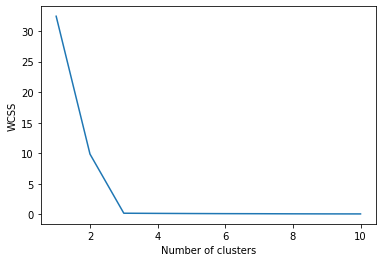

In [12]:
from sklearn.cluster import KMeans
wcss = [] 
for i in range(1, 11): 
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(feats) 
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.xlabel('Number of clusters')
plt.ylabel('WCSS') 
plt.show()

In [16]:
feats.groupby(['cluster']).mean()

,employment_type_percent_0_management_occupations,ethnic_percent_black,ethnic_percent_japanese,education_subject_percent_other,age_percent_25_to_29_years,employee_departure_time_percent_between_6_a.m._and_6:59_a.m.,industry_percent_mining_quarrying_and_oil_and_gas_extraction,industry_percent_wholesale_trade,industry_percent_administrative_and_support_waste_management_and_remediation_services
cluster,,,,,,,,,
0,0.076362,0.184571,0.001318,0.000061,0.064988,0.192674,0.000853,0.045947,0.071232
1,0.086178,0.081744,0.002551,0.000093,0.081051,0.152480,0.001643,0.035696,0.060650
2,0.094598,0.079159,0.001096,0.000079,0.064658,0.202002,0.006265,0.040950,0.051963
3,0.128219,0.060570,0.002946,0.000092,0.061435,0.147920,0.001471,0.052048,0.046326
4,0.135801,0.062102,0.005482,0.000186,0.114515,0.090862,0.001626,0.030907,0.041906


In [17]:
feats.cluster.value_counts()

2    24
1    20
3    15
0    12
4     9
Name: cluster, dtype: int64

In [27]:
feats

,,employment_type_percent_0_management_occupations,ethnic_percent_black,ethnic_percent_japanese,education_subject_percent_other,age_percent_25_to_29_years,employee_departure_time_percent_between_6_a.m._and_6:59_a.m.,industry_percent_mining_quarrying_and_oil_and_gas_extraction,industry_percent_wholesale_trade,industry_percent_administrative_and_support_waste_management_and_remediation_services,cluster
District_Name_x,Electoral_District_Number,,,,,,,,,,
Bourassa,24015,0.059050,0.239871,0.000153,0.000000,0.060029,0.200288,0.000583,0.043762,0.080173,0
Etobicoke North,35029,0.057114,0.234012,0.001240,0.000000,0.073026,0.190447,0.000547,0.041724,0.077708,0
York South--Weston,35120,0.066891,0.232085,0.002562,0.000000,0.068775,0.202388,0.000973,0.035566,0.085110,0
Humber River--Black Creek,35121,0.050746,0.228034,0.001160,0.000000,0.073911,0.205396,0.000823,0.040350,0.080700,0
Brampton West,35012,0.090949,0.188572,0.000657,0.000000,0.066192,0.199514,0.001381,0.052272,0.057506,0
...,...,...,...,...,...,...,...,...,...,...,...
Oshawa,35074,0.083320,0.047121,0.001198,0.000145,0.068197,0.200839,0.000966,0.036873,0.064327,2
Châteauguay--Lacolle,24021,0.102501,0.046625,0.000155,0.000291,0.055831,0.222948,0.002560,0.048444,0.042143,2
Saint Boniface--Saint Vital,46009,0.103211,0.045193,0.003301,0.000000,0.068808,0.171691,0.002058,0.035093,0.035916,3


In [28]:
feats2=feats.reset_index()#.set_index(['cluster','Electoral_District_Number'])
feats2=feats2[['Electoral_District_Number','cluster']]
feats2

,Electoral_District_Number,cluster
0,24015,0
1,35029,0
2,35120,0
3,35121,0
4,35012,0
...,...,...
75,35074,2
76,24021,2
77,46009,3
78,12004,2


In [36]:
main_df=full_df.reset_index()
main_df=main_df.merge(feats2,how='left',on='Electoral_District_Number').set_index('Electoral_District_Number')
main_df.cluster=main_df.cluster.fillna(5)
main_df.groupby(['cluster']).mean()

,2015_Bloc-Québécois_Votes,2015_Conservative_Votes,2015_Green-Party_Votes,2015_Liberal_Votes,2015_NDP-New-Democratic-Party_Votes,2015_Other_Votes,2015_Vote_Total,2015_Number_of_Polling_Stations,2015_Number_of_Electors,2015_Bloc-Québécois,2015_Conservative,2015_Green-Party,2015_Liberal,2015_NDP-New-Democratic-Party,2015_Other,2015_Percent_Riding_Votes_Liberal,2015_Percent_Riding_Votes_Bloc-Québécois,2015_Percent_Riding_Votes_Conservative,2015_Percent_Riding_Votes_Green-Party,2015_Percent_Riding_Votes_NDP-New-Democratic-Party,2015_Percent_Riding_Votes_Other,2015_Voter_Participation,2019_Bloc-Québécois_Votes,2019_Conservative_Votes,2019_Green-Party_Votes,2019_Liberal_Votes,2019_NDP-New-Democratic-Party_Votes,2019_Other_Votes,2019_Vote_Total,2019_Number_of_Polling_Stations,2019_Number_of_Electors,2019_Bloc-Québécois,2019_Conservative,2019_Green-Party,2019_Liberal,2019_NDP-New-Democratic-Party,2019_Other,2019_Percent_Riding_Votes_Liberal,2019_Percent_Riding_Votes_Bloc-Québécois,2019_Percent_Riding_Votes_Conservative,2019_Percent_Riding_Votes_Green-Party,2019_Percent_Riding_Votes_NDP-New-Democratic-Party,2019_Percent_Riding_Votes_Other,2019_Voter_Participation,2015-2019_Absolute_Change_Bloc-Québécois_Votes,2015-2019_EOE_Percent_Change_Bloc-Québécois_Votes,2015-2019_Absolute_Change_Conservative_Votes,2015-2019_EOE_Percent_Change_Conservative_Votes,2015-2019_Absolute_Change_Green-Party_Votes,2015-2019_EOE_Percent_Change_Green-Party_Votes,2015-2019_Absolute_Change_Liberal_Votes,2015-2019_EOE_Percent_Change_Liberal_Votes,2015-2019_Absolute_Change_NDP-New-Democratic-Party_Votes,2015-2019_EOE_Percent_Change_NDP-New-Democratic-Party_Votes,2015-2019_Absolute_Change_Other_Votes,2015-2019_EOE_Percent_Change_Other_Votes,2015-2019_Absolute_Change_Vote_Total,2015-2019_EOE_Percent_Change_Vote_Total,2015-2019_Absolute_Change_Number_of_Polling_Stations,2015-2019_EOE_Percent_Change_Number_of_Polling_Stations,2015-2019_Absolute_Change_Number_of_Electors,2015-2019_EOE_Percent_Change_Number_of_Electors,2015-2019_Absolute_Change_Bloc-Québécois,2015-2019_EOE_Percent_Change_Bloc-Québécois,2015-2019_Absolute_Change_Conservative,2015-2019_EOE_Percent_Change_Conservative,2015-2019_Absolute_Change_Green-Party,2015-2019_EOE_Percent_Change_Green-Party,2015-2019_Absolute_Change_Liberal,2015-2019_EOE_Percent_Change_Liberal,2015-2019_Absolute_Change_NDP-New-Democratic-Party,2015-2019_EOE_Percent_Change_NDP-New-Democratic-Party,2015-2019_Absolute_Change_Other,2015-2019_EOE_Percent_Change_Other,2015-2019_Absolute_Change_Percent_Riding_Votes_Liberal,2015-2019_EOE_Percent_Change_Percent_Riding_Votes_Liberal,2015-2019_Absolute_Change_Percent_Riding_Votes_Bloc-Québécois,2015-2019_EOE_Percent_Change_Percent_Riding_Votes_Bloc-Québécois,2015-2019_Absolute_Change_Percent_Riding_Votes_Conservative,2015-2019_EOE_Percent_Change_Percent_Riding_Votes_Conservative,2015-2019_Absolute_Change_Percent_Riding_Votes_Green-Party,2015-2019_EOE_Percent_Change_Percent_Riding_Votes_Green-Party,2015-2019_Absolute_Change_Percent_Riding_Votes_NDP-New-Democratic-Party,2015-2019_EOE_Percent_Change_Percent_Riding_Votes_NDP-New-Democratic-Party,2015-2019_Absolute_Change_Percent_Riding_Votes_Other,2015-2019_EOE_Percent_Change_Percent_Riding_Votes_Other,2015-2019_Absolute_Change_Voter_Participation,2015-2019_EOE_Percent_Change_Voter_Participation,employment_type_percent_0_management_occupations,employment_type_percent_1_business_finance_and_administration_occupations,employment_type_percent_2_natural_and_applied_sciences_and_related_occupations,employment_type_percent_3_health_occupations,employment_type_percent_4_occupations_in_education_law_and_social_community_and_government_services,employment_type_percent_5_occupations_in_art_culture_recreation_and_sport,employment_type_percent_6_sales_and_service_occupations,employment_type_percent_7_trades_transport_and_equipment_operators_and_related_occupations,employment_type_percent_8_natural_resources_agriculture_and_related_production_occupations,employ

In [ ]:
pd.options.display.max_columns = None
full_df

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [ ]:
model=RandomForestRegressor(random_state=12)
model.fit(X_train,y_train)

In [ ]:
y_pred=model.predict(X_test)
y_pred

In [ ]:
mean_squared_error(y_test,y_pred)

In [ ]:
model.feature_importances_

In [ ]:
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.index.name='fields'
feat_importances_df=feat_importances.to_frame(name='score').sort_values('score',ascending=False).reset_index()#.rename('index','fields')#,'0':'score'})
feat_importances_df.head(60)# feat_importances.nlargest(20)#.plot(kind='barh')

In [ ]:
model.get_params()

In [ ]:
predict_df=y_test.to_frame()
predict_df['predict_unemployment_rate']=y_pred
predict_df=predict_df.reset_index()

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(20, 110, num = 4)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 5, cv = 3, verbose=3, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

In [ ]:
rf_random.best_params_

In [ ]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

In [ ]:
base_accuracy = evaluate(model, X_test, y_test)

In [ ]:
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)

In [ ]:
print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

In [ ]:
mean_squared_error(y_test,y_pred)

In [ ]:
CV_feat_importances = pd.Series(best_random.feature_importances_, index=X.columns)
CV_feat_importances.index.name='fields'
CV_feat_importances_df=feat_importances.to_frame(name='score').sort_values('score',ascending=False).reset_index()#.rename('index','fields')#,'0':'score'})
CV_feat_importances_df.head(60)

In [ ]:
CV_predict_df=y_test.to_frame()
CV_predict_df['predict_unemployment_rate']=y_pred
CV_predict_df=CV_predict_df.reset_index()
CV_predict_df

In [ ]:
output_directory=directory.replace('\\output\\census_elections\\','\\output\\model_output\\')
CV_feat_importances_df.to_csv(f'{output_directory}CV_feat_importances_df.csv')
CV_predict_df.to_csv(f'{output_directory}CV_predict_df.csv')
feat_importances_df.to_csv(f'{output_directory}feat_importances_df.csv')
predict_df.to_csv(f'{output_directory}predict_df.csv')
print(directory)
print(output_directory)

print(model_directory)
model_directory=directory.replace('\\data\\output\\census_elections\\','\\models\\')
joblib.dump(model, f'{model_directory}base_rf_model.pkl', compress=9)
joblib.dump(best_random, f'{model_directory}best_rf_model.pkl', compress=9)